# **INTELIGENCIA DEL NEGOCIO / Business Intelligence**
## **ASSIGNMENT A1 - MULTILAYER PERCEPTRON**

**INSTRUCCIONES / RECOMENDACIONES**

- Se recomienda leer con detalle la descripción de cada una de las celdas.
- Las celdas que ya tienen código, se deberán ejecutar directamente.
- Las celdas que están vacías, se completarán con la implementación requerida en el notebook.
- No se incluirán más celdas de las establecidas en el presente notebook, por lo que la solución al mismo deberá implementarse exclusivamente en las celdas vacías.
- Scikit-Learn es un paquete muy útil para las operaciones de preprocesamiento de los datos, como estandarización, normalización, codificación, etc.
- Recuerda poner nombre a todas las layers de Keras, facilitará mucho las cosas a la hora de depurar errores.
- Si ves que un apartado es complejo, intenta escribir y ejecutarlo de forma simplificada (por ejemplo, con menos layers o con menos features) y después vaya amplíandolo.
- La entrega se realizará vía Moodle. Será necesario subir la solución a este notebook con el nombre: **NOMBRE_GRUPO.ipynb**

- **Fecha de Publicación: 05/02/2024**
- **Fecha de Entrega: 11/02/2024**
- **Test: 12/02/2024**


# Carga de librerías

In [ ]:
import pandas as pd
import random
random.seed(0)
import sklearn
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression

import tensorflow as tf

import matplotlib
import matplotlib.pyplot as plt

import numpy as np

In [ ]:
print("TF VERSION: ", tf.__version__)
print("SKLEARN VERSION: ", sklearn.__version__)
print("PANDAS VERSION: ", pd.__version__)
print("MATPLOTLIB VERSION: ", sklearn.__version__)

TF VERSION:  2.15.0
SKLEARN VERSION:  1.2.2
PANDAS VERSION:  1.5.3
MATPLOTLIB VERSION:  1.2.2


# Carga dataset

Se va a usar un dataset que contiene información socieconómica de ciudadanos americanos.

Queremos construir un modelo que realice predicciones a partir de estas features, utilizando la variable "income" como salida al modelo, la cual indica si la persona tiene unos ingresos superiores o inferirores a 50K. Es por tanto un problema de clasificación binaria.

Puede ver descripciones de los datos en el siguiente link:

https://archive.ics.uci.edu/ml/datasets/census+income

El dataset es muy grande, vamos a tomar solamente algunas de sus muestras.

In [ ]:
# Jesus url - I dowloaded the file and uploaded it to the sample_data folder in Colab
pd_data = pd.read_csv("./sample_data/income_evaluation.csv").sample(5_000)

# Download from google drive folder - Victor url
# pd_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Deep_Learning/Proyecto1/income_evaluation.csv").sample(5_000)

pd_data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
12725,39,Private,191342,Bachelors,13,Married-civ-spouse,Craft-repair,Husband,Asian-Pac-Islander,Male,0,0,40,Philippines,>50K
8794,33,Private,198211,HS-grad,9,Married-civ-spouse,Tech-support,Husband,White,Male,0,0,40,United-States,<=50K
20518,59,Private,31782,10th,6,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,45,United-States,>50K
11745,33,Private,167309,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,0,0,40,United-States,<=50K
13163,34,Federal-gov,149368,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,>50K


In [ ]:
for c in pd_data.columns:
    pd_data = pd_data.rename(columns={c: c.replace(" ", "")})

In [ ]:
TARGET = "income"
NUMERICAL_COLUMNS = ["age", "fnlwgt", "capital-gain", "capital-loss", "hours-per-week", "education-num"]
CATEGORICAL_COLUMNS = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex", "native-country"]

Divida el dataset en train y test. Un 20% en test puede ser suficiente.

In [ ]:
# Lo hacemos luego para simplificar la codificación y normalización
# pd_train, pd_test = sklearn.model_selection.train_test_split(pd_data, test_size=0.2, shuffle=True)

In [ ]:
# print("SAMPLES TRAIN: ", len(pd_train))
# print("SAMPLES TEST: ", len(pd_test))

# Analisis

Realice un análisis de las variables en el dataset.
Sugerencias:
- Histogramas de las variables
- Detectar y eliminar variables que no parezcan predecir el target o si presentan alta correlación con alguna otra de las features.
- En las variables categóricas, tomar aquellas etiquetas con baja volumetría y unirlas en un etiqueta default.


<Figure size 600x600 with 0 Axes>

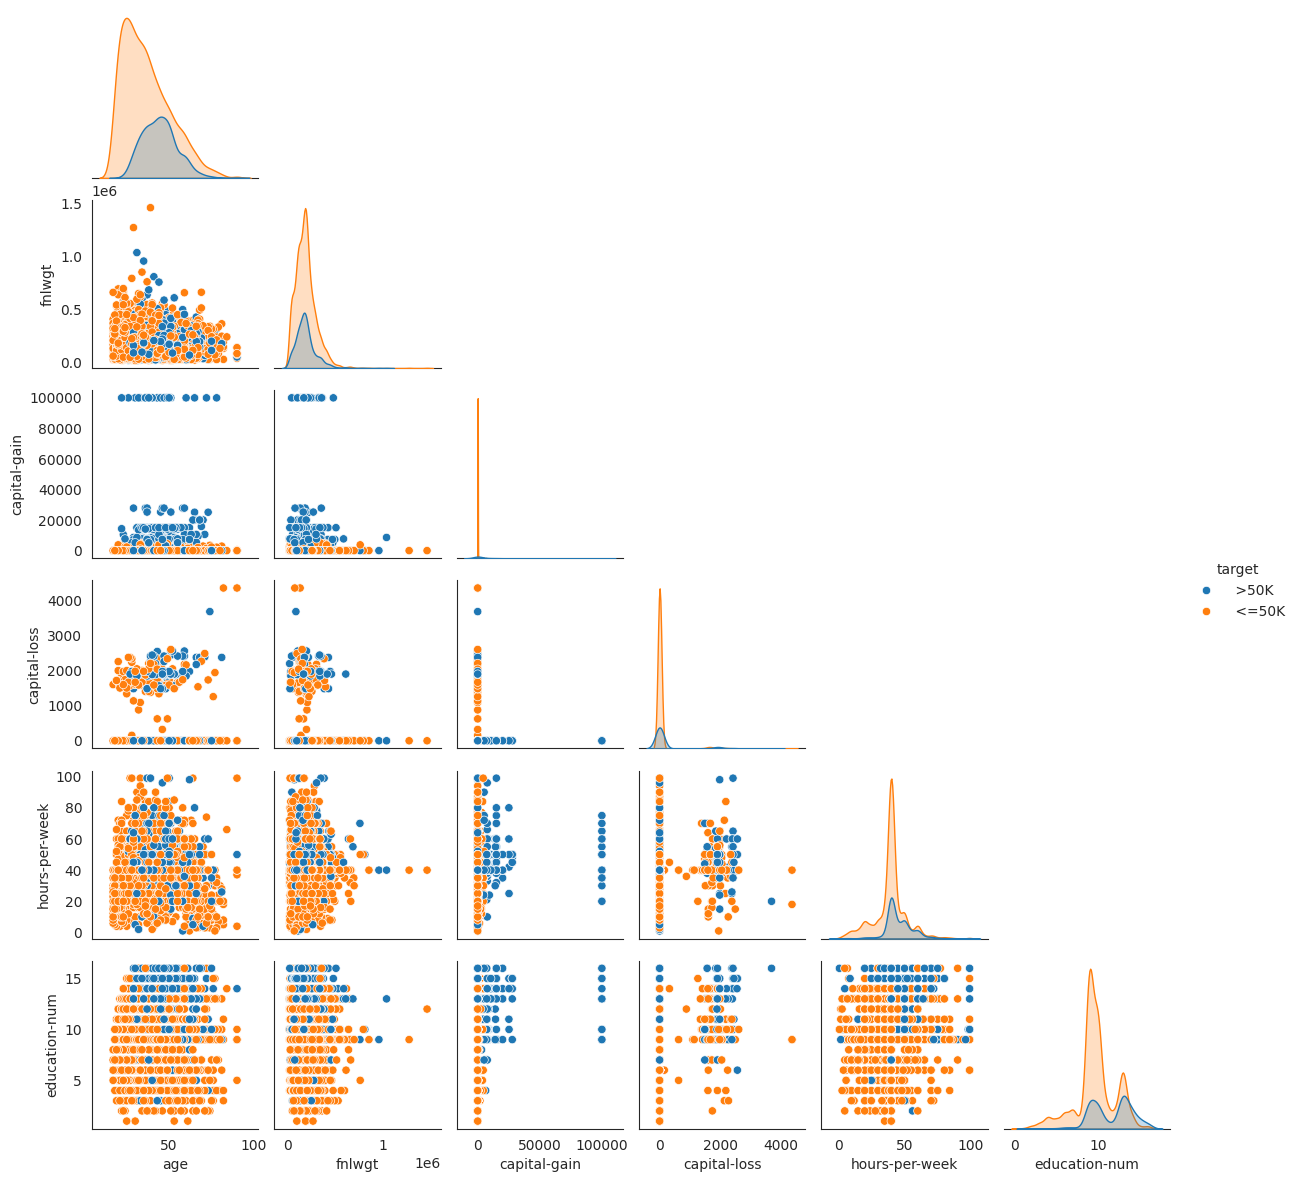

In [ ]:
# Here we can use Sklearn to get the correlation between variables and the target and then we can do a histogram of the most interesting variables and the target.
# Look how to do the categorical joint.
import seaborn as sns

X = pd_data

# Visualize the correlation matrix using a heatmap
fig_size = len(NUMERICAL_COLUMNS)
plt.figure(figsize=(fig_size,fig_size))
sns.set_style("white")
plt_df = X[NUMERICAL_COLUMNS].copy()
plt_df["target"] = X[TARGET]
sns.pairplot(plt_df, hue="target", corner=True, height=2)

# With this plot we see that some numerical value (fnlwgt, capital-gain and loss) do not explain the variance of the distribution
# Age Has a different distribution and can differentiate the variable for young people
# hours per week and education differ in the tail of the distribution. We will choose education for our model as it allocates better
# the distribution when ploted vs age.

# Preprocesado del target

Aplique una trasformación en el target para convertirlo en unos y ceros.

In [ ]:
pd_data[TARGET] = pd_data[TARGET].astype(str).apply(lambda x:x.strip())
pd_data[TARGET] = pd_data[TARGET].map(lambda x: 0 if x == "<=50K" else 1)
pd_data[TARGET].unique()

array([1, 0])

# Preprocesado de las variables numéricas

Vamos a comenzar construyendo un modelo usando solo variables numéricas ya que son las más sencillas de tratar. Para empezar, aplique una transformación en las features para normalizarlas a media cero y desviación típica uno.

In [ ]:
from sklearn.preprocessing import StandardScaler # Para media 0 y sd 1

# Separate numerical and categorical columns
pd_data_num = pd_data[NUMERICAL_COLUMNS]
pd_data_cat = pd_data[CATEGORICAL_COLUMNS + [TARGET]]

# Initialize StandardScaler
scaler = StandardScaler()

# Normalize numerical columns
pd_data_num_normalized = pd.DataFrame(scaler.fit_transform(pd_data_num), columns=pd_data_num.columns)

#Drop index for Categorical values dataframe
pd_data_cat_reset_index = pd_data_cat.reset_index(drop=True)
# Concatenate normalized numerical columns with categorical columns
pd_data_normalized = pd.concat([pd_data_num_normalized, pd_data_cat_reset_index], axis=1)


# Modelo baseline de variables continuas

Construya una regresión logística a partir de las features transformadas. Use el dataset de test para evaluar el modelo y calcule el accuracy, precision, recall, f1 y área bajo la curva. ¿Cuál crees que es la mejor métrica para evaluar este problema?

In [ ]:
# Create a logistic Model - sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Separate in train and test
pd_train, pd_test = sklearn.model_selection.train_test_split(pd_data_normalized, test_size=0.2, shuffle=True)

# Prepare X_train and y_train
X_train = pd_train[NUMERICAL_COLUMNS]
y_train = pd_train[TARGET]

# Prepare X_test and y_test
X_test = pd_test[NUMERICAL_COLUMNS]
y_test = pd_test[TARGET]

# Initialize Logistic Regression Object
log_reg_numeric = LogisticRegression(max_iter=1000)



In [ ]:
# Train the model
log_reg_numeric.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
# Predict on test data
y_pred = log_reg_numeric.predict(X_test)

# Print evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-Score:", f1_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


# CUANDO SE TIENE UN DATASET CON UN TARGET DESBALANCEADO (MUCHO DE UNA CATEGORÍA Y POCO DE OTRO),
# ES MEJOR MIRAR EL F1-SCORE.

Accuracy: 0.823
Precision: 0.7448275862068966
Recall: 0.43548387096774194
F1-Score: 0.549618320610687

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.95      0.89       752
           1       0.74      0.44      0.55       248

    accuracy                           0.82      1000
   macro avg       0.79      0.69      0.72      1000
weighted avg       0.81      0.82      0.81      1000



# Modelo Deep Learning

Construya un perceptrón multicapa para predecir el target.

In [ ]:
X_train.head()

,age,fnlwgt,capital-gain,capital-loss,hours-per-week,education-num
3155,-1.442033,-0.544873,-0.145536,-0.217718,-0.374017,-2.787949
806,0.110273,-0.122888,-0.145536,-0.217718,0.765335,1.124523
621,-0.481082,-0.177331,-0.145536,-0.217718,-0.048488,0.733275
931,1.514740,0.008129,-0.145536,-0.217718,-0.048488,1.124523
1341,-0.259324,-1.395726,-0.145536,-0.217718,-0.048488,-0.440466


## Construcción del modelo
Construye el modelo con Keras. Utilice varias capas (entre 1 y 2 serán suficiente). Puede probar varios valores para el número de capas y el tamaño de las mismas. Considere añadir capas de Dropout entre algunas (o todas) las capas.

In [ ]:
# Create a model with keras. Change Depth. Try Dropout layers.
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten, Dense, Dropout

input_dim = len(NUMERICAL_COLUMNS)
output_dim = 1
hidden_units = 128
dropout_rate = 0.2
learning_rate = 0.001


# Using functional API
inputs = Input(shape=(input_dim, ))
X_train_tensor = tf.identity(inputs)

# Adding flattening layer
flat_layer = Flatten()(inputs)

# Configuring the intermediate and output layers

intermediate_layer = Dense(hidden_units, activation='relu')(flat_layer)
dropout_layer = Dropout(dropout_rate)(intermediate_layer) #
outputs = Dense(output_dim, activation='sigmoid')(dropout_layer)

# Constructing the model
numeric_model = tf.keras.Model(inputs=inputs, outputs=outputs)

## Compilación del modelo
Compile el modelo con adam como función de optimización. Elija la función de pérdida acorde con el objetivo que buscamos. Además, elija algunas métricas que nos permitan evaluar el modelo.

In [ ]:
# Compile model with adam and metrics

# Compiling the model
numeric_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

## Entrenamiento

Entrene el modelo. Elija el tamaño del batch y el número de épocas necesario. Utilice algunas de las técnicas mencionadas en clase para evitar el overfitting del modelo.

In [ ]:
# Epoch, Batch. Avoid Overfitting.
epochs = 100
batch_size = 32
history = numeric_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                    verbose=1, validation_split=0.2)

Epoch 1/100
100/100 [==============================] - 1s 8ms/step - loss: 0.4956 - accuracy: 0.7828 - val_loss: 0.4408 - val_accuracy: 0.7975
Epoch 2/100
100/100 [==============================] - 0s 3ms/step - loss: 0.4101 - accuracy: 0.8103 - val_loss: 0.4270 - val_accuracy: 0.8012
Epoch 3/100
100/100 [==============================] - 0s 4ms/step - loss: 0.3990 - accuracy: 0.8106 - val_loss: 0.4225 - val_accuracy: 0.8000
Epoch 4/100
100/100 [==============================] - 0s 4ms/step - loss: 0.3938 - accuracy: 0.8163 - val_loss: 0.4205 - val_accuracy: 0.8000
Epoch 5/100
100/100 [==============================] - 0s 4ms/step - loss: 0.3906 - accuracy: 0.8150 - val_loss: 0.4148 - val_accuracy: 0.8050
Epoch 6/100
100/100 [==============================] - 0s 4ms/step - loss: 0.3883 - accuracy: 0.8181 - val_loss: 0.4129 - val_accuracy: 0.8062
Epoch 7/100
100/100 [==============================] - 0s 4ms/step - loss: 0.3853 - accuracy: 0.8178 - val_loss: 0.4136 - val_accuracy: 0.8062

El método fit devuelve un objeto de tipo history con las métricas obtenidas durante el entrenamiento. Analice el resultado de ejecutar 'history.history' y dibuje las métricas en las distintas épocas.

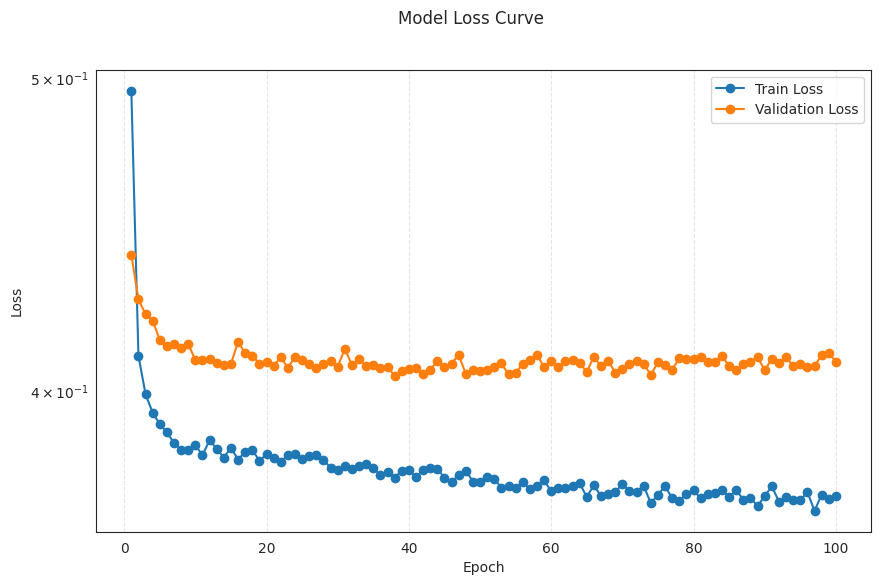

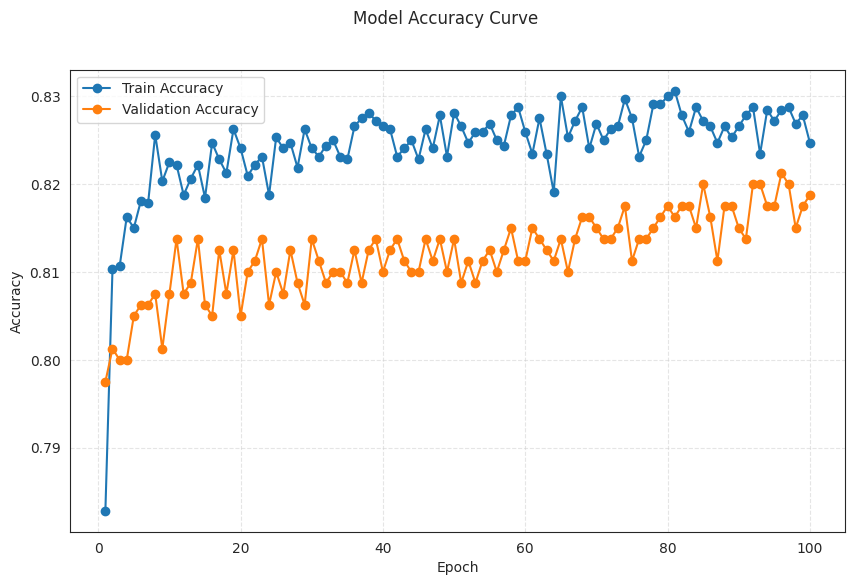

In [ ]:
# Analize history.history
import matplotlib.pyplot as plt

# Get the loss and val_loss lists
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']

# Plotting the loss curve
plt.figure(figsize=(10,6))
plt.suptitle('Model Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.semilogy() # Show exponential scale for clarity
plt.plot(range(1, len(loss_values)+1), loss_values, '-o', label='Train Loss')
plt.plot(range(1, len(val_loss_values)+1), val_loss_values, '-o', label='Validation Loss')
plt.legend()
plt.grid(linestyle='--', alpha=0.5)
plt.show()


# Get the accuracy and val_accuracy lists
acc_values = history.history['accuracy']
val_acc_values = history.history['val_accuracy']

# Plotting the accuracy curve
plt.figure(figsize=(10,6))
plt.suptitle('Model Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(range(1, len(acc_values)+1), acc_values, '-o', label='Train Accuracy')
plt.plot(range(1, len(val_acc_values)+1), val_acc_values, '-o', label='Validation Accuracy')
plt.legend()
plt.grid(linestyle='--', alpha=0.5)
plt.show()

## Evaluación

Utilice el dataset de test para conseguir las métricas que se calcularon con el modelo baseline. Compare los resultados con el baseline.

In [ ]:
# Test Metrics
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred)

# Compute evaluation metrics
accuracy = confusion_mtx[0][0] + confusion_mtx[1][1] / sum(confusion_mtx.flatten())
precision = confusion_mtx[1][1] / sum(confusion_mtx[1])
recall = confusion_mtx[1][1] / sum(confusion_mtx[1])

# Avoid Overwrite
f1_score_metric = 2 * (precision * recall) / (precision + recall)

print(f'Confusion Matrix:\n{confusion_mtx}')
print(f'\nTest Accuracy: {accuracy:.3f}')
print(f'Test Precision: {precision:.3f}')
print(f'Test Recall: {recall:.3f}')
print(f'Test F1-Score: {f1_score_metric:.3f}')

Confusion Matrix:
[[715  37]
 [140 108]]

Test Accuracy: 715.108
Test Precision: 0.435
Test Recall: 0.435
Test F1-Score: 0.435


## Impacto del learning rate

Reentrene el modelo varias veces usando diferentes learning rate (por ejemplo, en escala logarítmica valores entre 1e-6 y 1) y dibuje los resultados en validación de la métrica de loss para cada valor del learning rate.

¿cuál es el mejor valor del learning rate?

No olvidar reinicializar los pesos entre entrenamiento y entrenamiento. Para ello, se puede usar la siguiente función:

In [ ]:
from tensorflow import keras
def reinitialize_model(model):
    weights = []
    initializers = []
    for layer in model.layers:
        if isinstance(layer, (keras.layers.Dense, keras.layers.Conv2D)):
            weights += [layer.kernel, layer.bias]
            initializers += [layer.kernel_initializer, layer.bias_initializer]
        elif isinstance(layer, keras.layers.BatchNormalization):
            weights += [layer.gamma, layer.beta, layer.moving_mean, layer.moving_variance]
            initializers += [layer.gamma_initializer,
                           layer.beta_initializer,
                           layer.moving_mean_initializer,
                           layer.moving_variance_initializer]
    for w, init in zip(weights, initializers):
        w.assign(init(w.shape, dtype=w.dtype))


In [ ]:
# Train model with different learning rates. reinitialize the model between trainings to reset weights.
learning_rates = np.logspace(-6, 0, base=10, num=6)

In [ ]:
# Visualize Loss vs learning rate
training_losses = []
valid_losses = []

for lr in learning_rates:
    # Establecer el learning rate actual
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    numeric_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Historial de entrenamiento
    history = numeric_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0)

    # Agregar listas de pérdida
    training_losses.append(history.history['loss'])
    valid_losses.append(history.history['val_loss'])

    # Reiniciar pesos después de cada entrenamiento
    reinitialize_model(numeric_model)

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values e

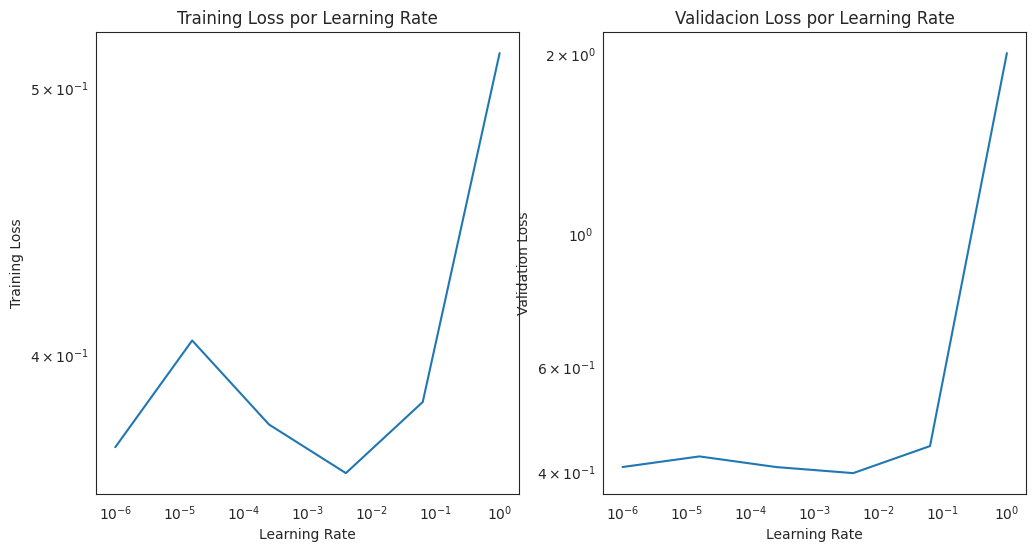

In [ ]:
# Compare learning rates
last_training_losses =  []
last_validation_losses =  []

# Only plot the last epoch error
for i in range(len(learning_rates)):
  last_training_losses.append(training_losses[i][epochs-1])
  last_validation_losses.append(valid_losses[i][epochs-1])


fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].semilogy(learning_rates, last_training_losses)
ax[0].set_xscale('log')
ax[0].set_xlabel('Learning Rate')
ax[0].set_ylabel('Training Loss')
ax[0].set_title('Training Loss por Learning Rate')

ax[1].semilogy(learning_rates, last_validation_losses)
ax[1].set_xscale('log')
ax[1].set_xlabel('Learning Rate')
ax[1].set_ylabel('Validation Loss')
ax[1].set_title('Validacion Loss por Learning Rate');

# Preprocesado de variables categóricas

Vamos a construir un modelo con las variables categóricas. Comencemos generando variables one hot para poder alimentar un modelo con ellas.

Positive Samples Ratio: 31.75%

Category Column 'workclass' Analysis:
Unique Values: 8
Null / NA Values Count: 0
Percentage Of Total Rows With Nulls: 0.00 %



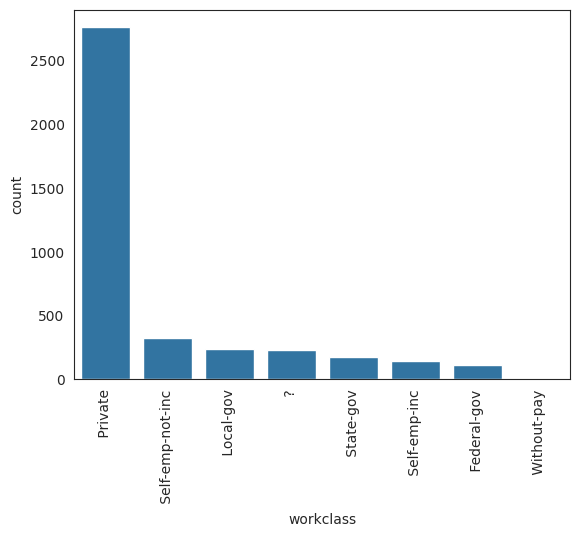


Top 5 Most Common Values And Their Frequencies:
 Private             2760
 Self-emp-not-inc     329
 Local-gov            236
 ?                    233
 State-gov            179
Name: workclass, dtype: int64

Category Column 'education' Analysis:
Unique Values: 16
Null / NA Values Count: 0
Percentage Of Total Rows With Nulls: 0.00 %



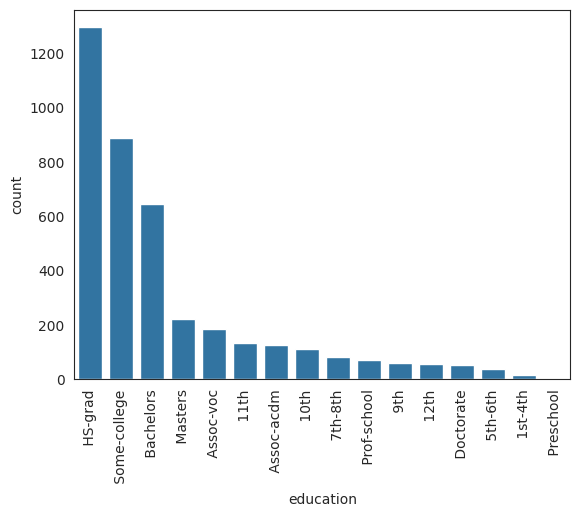


Top 5 Most Common Values And Their Frequencies:
 HS-grad         1295
 Some-college     890
 Bachelors        647
 Masters          224
 Assoc-voc        187
Name: education, dtype: int64

Category Column 'marital-status' Analysis:
Unique Values: 7
Null / NA Values Count: 0
Percentage Of Total Rows With Nulls: 0.00 %



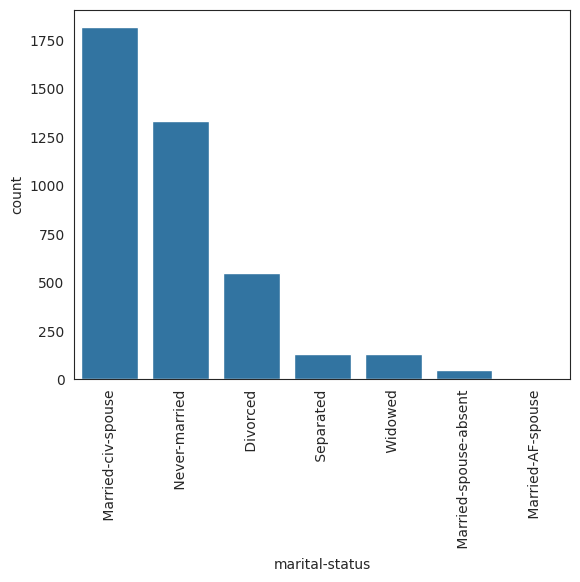


Top 5 Most Common Values And Their Frequencies:
 Married-civ-spouse    1814
 Never-married         1330
 Divorced               546
 Separated              132
 Widowed                128
Name: marital-status, dtype: int64

Category Column 'occupation' Analysis:
Unique Values: 15
Null / NA Values Count: 0
Percentage Of Total Rows With Nulls: 0.00 %



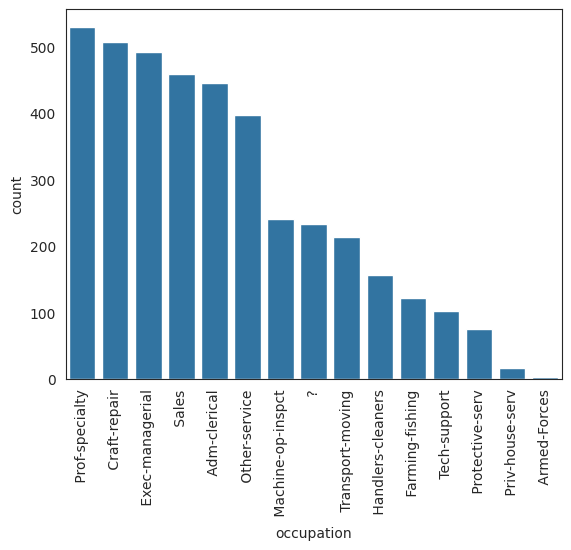


Top 5 Most Common Values And Their Frequencies:
 Prof-specialty     530
 Craft-repair       508
 Exec-managerial    492
 Sales              460
 Adm-clerical       446
Name: occupation, dtype: int64

Category Column 'relationship' Analysis:
Unique Values: 6
Null / NA Values Count: 0
Percentage Of Total Rows With Nulls: 0.00 %



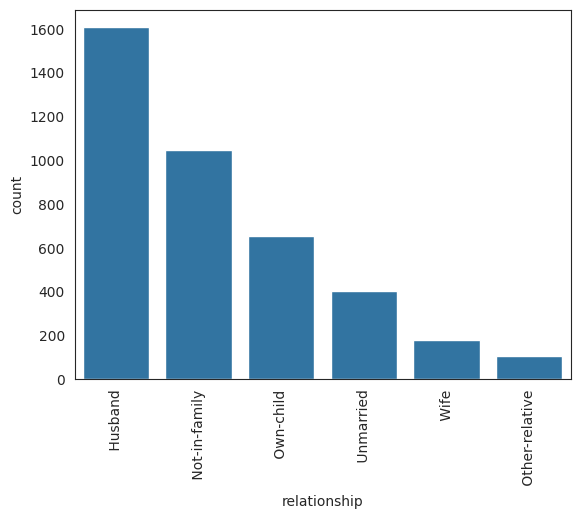


Top 5 Most Common Values And Their Frequencies:
 Husband          1607
 Not-in-family    1049
 Own-child         654
 Unmarried         404
 Wife              179
Name: relationship, dtype: int64

Category Column 'race' Analysis:
Unique Values: 5
Null / NA Values Count: 0
Percentage Of Total Rows With Nulls: 0.00 %



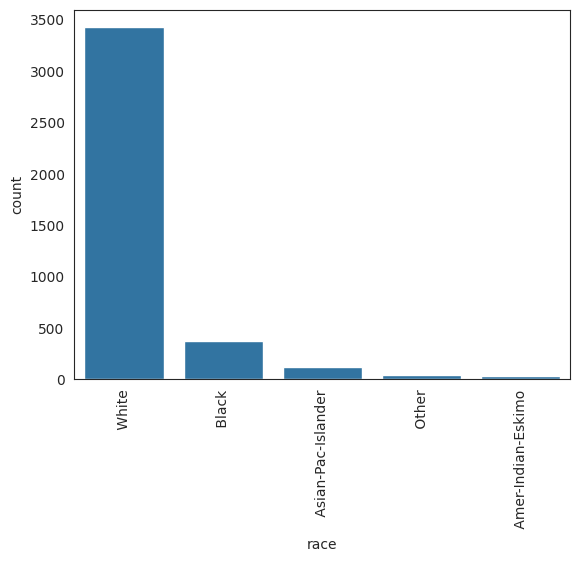


Top 5 Most Common Values And Their Frequencies:
 White                 3425
 Black                  378
 Asian-Pac-Islander     119
 Other                   46
 Amer-Indian-Eskimo      32
Name: race, dtype: int64

Category Column 'sex' Analysis:
Unique Values: 2
Null / NA Values Count: 0
Percentage Of Total Rows With Nulls: 0.00 %



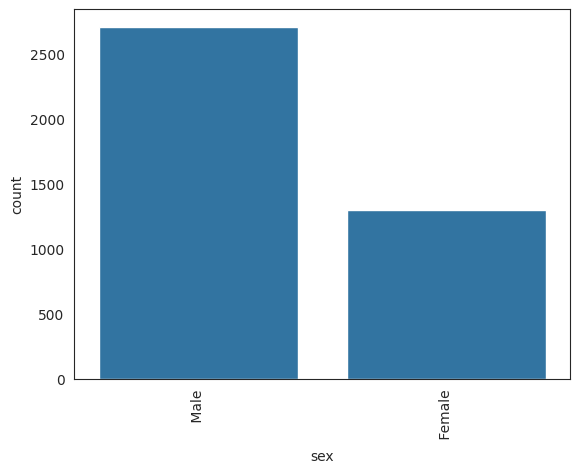


Top 5 Most Common Values And Their Frequencies:
 Male      2703
 Female    1297
Name: sex, dtype: int64

Category Column 'native-country' Analysis:
Unique Values: 38
Null / NA Values Count: 0
Percentage Of Total Rows With Nulls: 0.00 %



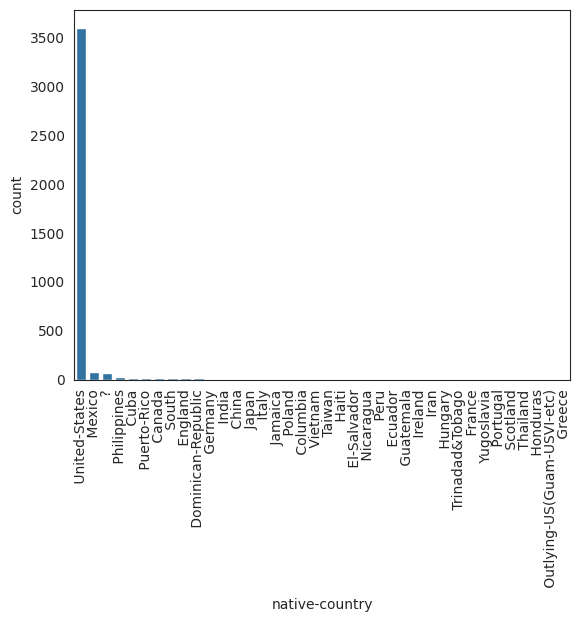


Top 5 Most Common Values And Their Frequencies:
 United-States    3604
 Mexico             77
 ?                  72
 Philippines        22
 Cuba               17
Name: native-country, dtype: int64


In [ ]:
# one hot of categorical variables. Join the small ones.

import seaborn as sns


def replace_question_marks(column):
    return column.replace('?', column.mode()[0])


for cat_col in CATEGORICAL_COLUMNS:
    pd_train[cat_col] = replace_question_marks(pd_train[cat_col])
    pd_test[cat_col] = replace_question_marks(pd_test[cat_col])

negative_samples = sum((pd_train['income']==0))
positive_samples = sum((pd_train['income']==1))
imbalance_ratio = float(positive_samples)/negative_samples
print(f"Positive Samples Ratio: {round(imbalance_ratio*100, 2)}%")

for cat_col in CATEGORICAL_COLUMNS:
    print(f"\nCategory Column '{cat_col}' Analysis:")
    print(f"Unique Values: {len(pd_train[cat_col].unique())}")
    print(f"Null / NA Values Count: {pd_train[cat_col].isna().sum()}")
    print(f"Percentage Of Total Rows With Nulls: {pd_train[cat_col].isna().mean() * 100 :.2f} %\n")

  # Sort the unique values in descending order based on their counts
    sorted_values = pd_train[cat_col].value_counts()[::].index

    # Optional: Display top n values frequencies
    ax = sns.countplot(x=cat_col, data=pd_train, order=sorted_values)
    plt.xticks(rotation=90)
    plt.show()


    print("\nTop 5 Most Common Values And Their Frequencies:");
    print(pd_train[cat_col].value_counts().head());

In [ ]:
def one_hot_encoding(df, column):
    dummies = pd.get_dummies(df[column], prefix=[column])
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(columns=[column])
    return df

pd_data_dummies = pd_data_normalized.copy()

for cat_col in CATEGORICAL_COLUMNS:
    pd_data_dummies = one_hot_encoding(pd_data_dummies, cat_col)

print("There are ",len(pd_data_dummies.columns)," in the dataframe with one-hot vector encoding")

There are  106  in the dataframe with one-hot vector encoding


# Modelo baseline de todas las variables

Vuelva a realizar un modelo de regresión logística usando las variables categóricas.

In [ ]:
# Separate in train and test
pd_train_dummies, pd_test_dummies = sklearn.model_selection.train_test_split(pd_data_dummies, test_size=0.2, shuffle=True)

# Volvemos a separar en X e Y.

# Prepare X_train and y_train
X_train = pd_train_dummies[NUMERICAL_COLUMNS]
y_train = pd_train_dummies[TARGET]

# Prepare X_test and y_test
X_test = pd_test_dummies[NUMERICAL_COLUMNS]
y_test = pd_test_dummies[TARGET]

# Initialize Logistic Regression Object
log_reg_numeric = LogisticRegression(max_iter=1000)

# Train the model
log_reg_numeric.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
# Predict on test data
y_pred = log_reg_numeric.predict(X_test)

print(type(y_test))
print(type(y_pred))
# Print evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-Score:", f1_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
Accuracy: 0.82
Precision: 0.7
Recall: 0.4152542372881356
F1-Score: 0.5212765957446808

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.95      0.89       764
           1       0.70      0.42      0.52       236

    accuracy                           0.82      1000
   macro avg       0.77      0.68      0.71      1000
weighted avg       0.81      0.82      0.80      1000



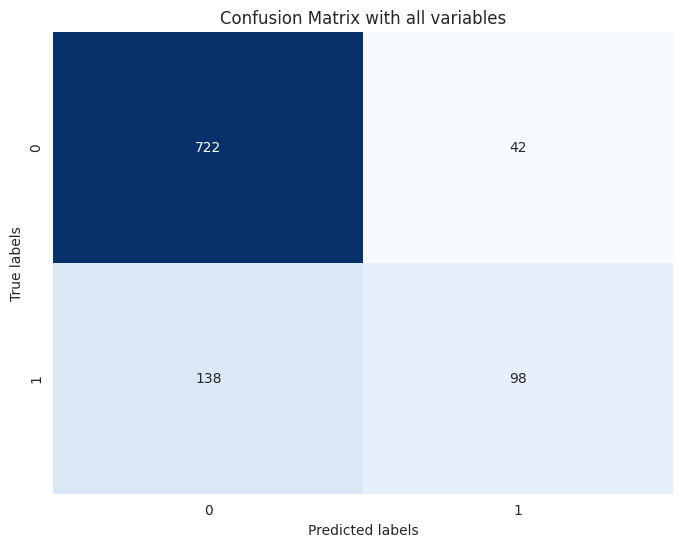

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix with all variables")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()

# Modelo Deep Learning con todas las variables


## Construcción del modelo
Construye el modelo con Keras. Aunque hay muchas maneras de hacerlo, se recomienda construir un modelo que tenga una entrada para las variables numéricas y otra entrada por cada una de las variables categóricas.

Cada variable categórica debe "enganchar" con una capa de Embedding, de forma que cada variable se transforme en un vector de dimensión D (puede elegir el valor de D, o incluso hacer que varíe según la variable en cuestión). Así debe finalizar teniendo un tensor asociado a cada una de las features.

Una los tensores en uno solo usando alguna capa de Merge (Concatenación, Media ...) Finalmente, aplique varias capas ocultas estudiando varias posibilidades.

In [ ]:
len(pd_data_cat_reset_index)

5000

In [ ]:
from tensorflow.keras.layers import Input, Embedding, Flatten, concatenate, Dense
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder

# One input for Numerical and one for each categorical. Use Embeddings and merge all tensors in one.

# WE USE FULL DATASET FOR THE ENCODING AND EMBEDDINGS, TO CONSIDER ALL POSSIBLE CATEGORIES.
# WE SPLIT IN TRAIN/TEST LATER.

# Input numerical
input_num = pd_data_num_normalized

#Input categorical (before embedding)
input_cat = pd_data_cat_reset_index[CATEGORICAL_COLUMNS].copy()

# Y training
y_train = pd_data_cat_reset_index[TARGET].copy()


# Convert categorical columns to integer-encoded representations
label_encoders = {}
for col in CATEGORICAL_COLUMNS:
    label_encoders[col] = LabelEncoder()
    input_cat[col] = label_encoders[col].fit_transform(input_cat[col])


# Define input layers for numerical and categorical columns
numerical_inputs = Input(shape=(len(input_num.columns),))
# EL PROFEESOR CONECTA UNA CAPA DENSA PARA LA VARIABLE NUMÉRICA CON 10 NEURONAS PARA QUE TENGA UNA SALIDA IGUAL AL DE LA CATEGÓRICA.

categorical_inputs = [Input(shape=(1,)) for _ in input_cat.columns]


# Define embedding layers for categorical columns
embedding_layers = []
for i, col in enumerate(CATEGORICAL_COLUMNS):
    # Count the number of categories in a column
    num_categories = len(label_encoders[col].classes_)
    # Calculate embedding dimensions
    embed_dim = min(np.ceil(num_categories / 2), 50)  # Rule of thumb for embedding dimensions
    # Create the embedding layer with input being the number of categories and output the calculated dimension.
    # Takes the categorical input layer as an input. Creates num_categories number of vectors with the dimensions calculated.
    embed_layer = Embedding(input_dim=num_categories, output_dim=int(embed_dim), name=f'{col}_embedding')(categorical_inputs[i])
    # Flatten the embedding vectors into an array.
    flatten_layer = Flatten(name=f'{col}_flatten')(embed_layer)
    embedding_layers.append(flatten_layer)

# Concatenate all input layers (The input is the original data already transformed to its encoding values.)
concatenated_inputs = concatenate([numerical_inputs] + categorical_inputs)



# Define the neural network model architecture
dense_layer_1 = Dense(128, activation='relu')(concatenated_inputs)
dense_layer_2 = Dense(128, activation='elu')(dense_layer_1)
dense_layer_2 = Dense(64, activation='relu')(dense_layer_2)
output_layer = Dense(1, activation='sigmoid')(dense_layer_2)

# Create the model with concatenated inputs.
model = Model(inputs=concatenated_inputs, outputs=output_layer)


In [ ]:
model.summary()
# The input layer has an output shape of 14, which is all the dimensions of the input matrix.
# These 14 neurons will be connected to a dense layer of 128
# That layer will be connected to 64 more neurons
# Then the 64 will be connected to 1 output neuron.

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 14)]              0         
                                                                 
 dense_2 (Dense)             (None, 128)               1920      
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 26753 (104.50 KB)
Trainable params: 26753 (104.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Compilación del modelo
Compile el modelo con adam como función de optimización. Elija la función de pérdida acorde con el objetivo que buscamos. Además, elija algunas métricas que nos permitan evaluar el modelo.

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, AUC

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), AUC()])

## Entrenamiento

Entrene el modelo. Elija el tamaño del batch y el número de épocas necesario.

In [ ]:
# Transform all categories of train to their numerical value

# (ONLY RUN ONCE)

for column, encoder in label_encoders.items():
    pd_data_normalized[column] = encoder.transform(pd_data_normalized[column])


pd_data_normalized.head()

,age,fnlwgt,capital-gain,capital-loss,hours-per-week,education-num,workclass,education,marital-status,occupation,relationship,race,sex,native-country,income
0,0.036354,0.023248,-0.145536,-0.217718,-0.048488,1.124523,3,9,2,3,0,1,1,28,1
1,-0.407162,0.087316,-0.145536,-0.217718,-0.048488,-0.440466,3,11,2,13,0,4,1,37,0
2,1.514740,-1.464979,-0.145536,-0.217718,0.358424,-1.614207,3,0,2,14,0,4,1,37,1
3,-0.407162,-0.200909,-0.145536,-0.217718,-0.048488,1.124523,3,9,4,1,1,4,1,37,0
4,-0.333243,-0.368246,-0.145536,-0.217718,-0.048488,1.907017,1,14,2,10,0,4,1,37,1


In [ ]:
# Separate in train and test
pd_train_normalized, pd_test_normalized = sklearn.model_selection.train_test_split(pd_data_normalized, test_size=0.2, shuffle=True)


# TRAIN
X_train = pd_train_normalized.iloc[:, :-1].copy()
y_train = pd_train_normalized["income"].copy()
X_train_tensor = tf.convert_to_tensor(X_train)
y_train_tensor = tf.convert_to_tensor(y_train)

# TEST
X_test = pd_test_normalized.iloc[:, :-1].copy()
y_test = pd_test_normalized["income"].copy()
X_test_tensor = tf.convert_to_tensor(X_test)
y_test_tensor = tf.convert_to_tensor(y_test)

# Fit the model to the training data
# X_train = concatenate([input_num] + [input_cat[col] for col in CATEGORICAL_COLUMNS])

model.fit(x=X_train_tensor, y=y_train_tensor, epochs=10, batch_size=50, validation_split=0.2)

Epoch 1/10
64/64 [==============================] - 3s 12ms/step - loss: 0.5310 - accuracy: 0.7625 - precision: 0.4962 - recall: 0.1715 - auc: 0.7009 - val_loss: 0.4062 - val_accuracy: 0.8037 - val_precision: 0.6970 - val_recall: 0.2514 - val_auc: 0.8336
Epoch 2/10
64/64 [==============================] - 0s 4ms/step - loss: 0.4155 - accuracy: 0.8081 - precision: 0.6682 - recall: 0.3773 - auc: 0.8236 - val_loss: 0.3993 - val_accuracy: 0.8075 - val_precision: 0.8085 - val_recall: 0.2077 - val_auc: 0.8539
Epoch 3/10
64/64 [==============================] - 0s 4ms/step - loss: 0.3937 - accuracy: 0.8122 - precision: 0.6653 - recall: 0.4169 - auc: 0.8465 - val_loss: 0.4175 - val_accuracy: 0.8100 - val_precision: 0.5643 - val_recall: 0.7432 - val_auc: 0.8660
Epoch 4/10
64/64 [==============================] - 0s 4ms/step - loss: 0.3842 - accuracy: 0.8178 - precision: 0.6719 - recall: 0.4512 - auc: 0.8533 - val_loss: 0.3657 - val_accuracy: 0.8313 - val_precision: 0.7069 - val_recall: 0.4481 -

## Evaluación

Utilice el dataset de test para conseguir las métricas que se calcularon con el modelo baseline. Compare los resultados con el baseline.

In [ ]:
test_loss, test_acc, test_prec, test_rec, test_auc = model.evaluate(X_test,  y_test)

print('\nTest accuracy:', test_acc)

32/32 [==============================] - 1s 2ms/step - loss: 0.3627 - accuracy: 0.8260 - precision: 0.7709 - recall: 0.5092 - auc: 0.8885

Test accuracy: 0.8259999752044678


32/32 [==============================] - 0s 2ms/step
<class 'numpy.ndarray'>
Accuracy: 0.826
Precision: 0.770949720670391
Recall: 0.5092250922509225
F1-Score: 0.6133333333333333

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.94      0.89       729
           1       0.77      0.51      0.61       271

    accuracy                           0.83      1000
   macro avg       0.80      0.73      0.75      1000
weighted avg       0.82      0.83      0.81      1000



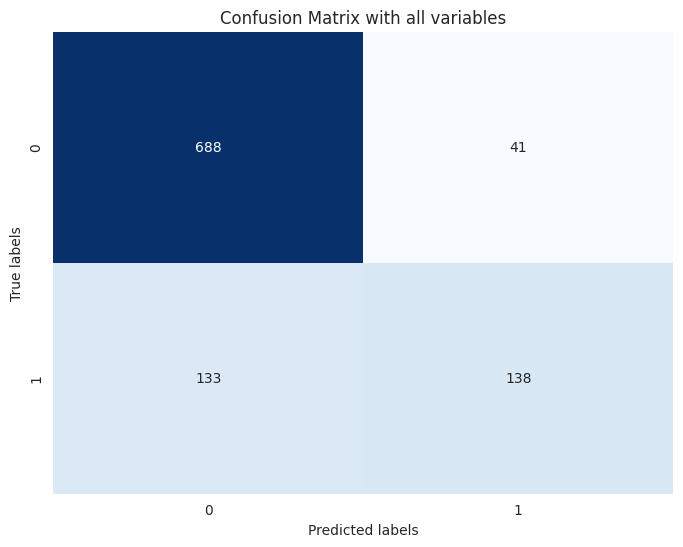

In [ ]:
# Model Predictions
y_pred = model.predict(X_test)

# Convert output to 1 or 0 using 0.5 as the threshold.
y_pred_labels = (y_pred >= 0.5).astype(int)

print(type(y_pred_labels))


# Print evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred_labels))
print("Precision:", precision_score(y_test, y_pred_labels))
print("Recall:", recall_score(y_test, y_pred_labels))
print("F1-Score:", f1_score(y_test, y_pred_labels))
print("\nClassification Report:\n", classification_report(y_test, y_pred_labels))


cm = confusion_matrix(y_test, y_pred_labels)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix with all variables")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()



La accuracy y precisión del modelo multicapa es un poco mejor que la regresión logística. De todos modos, el recall y el F1 son un poco inferiores.

No se ha notado un incremento notable en la capacidad de generalización del modelo y en su capacidad de predecir frene a la regresión logística.